## Homework 2

### 1.
Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both `Bachelor semestre 1` and `Bachelor semestre 6`. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

In [12]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import scipy.stats as stats
import numpy as np
import re

%matplotlib inline

First, we fetch all the data we need from ISA. We parse the tables in order to only keep a few informations for each line. We keep track of the Name, Sciper, Civility, Bachelor level and year for each entry. 

In [13]:
#ISA base url. This is the page that displays the form
isa_base_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'

#list of ID of academic periods, from 2007-2008 to 2016-2017
academic_periods = [978181, 978187, 978195, 39486325, 123455150, 123456101, 213637754, 213637922, 213638028, 355925344]

#list of ID of semesters (only for bachelor 1, 5 and 6)
semesters = [249108, 942120, 942175]

#list of parameters (found using Postman)
params_dict = {'ww_x_GPS': -1,
               'ww_i_reportmodel': 133685247,
               'ww_i_reportModelXsl': 133685270,
               'ww_x_UNITE_ACAD': 249847,
               'ww_x_PERIODE_ACAD': 978181,
               'ww_x_PERIODE_PEDAGO': 249108,
               'ww_x_HIVERETE': 'null',
               }

#empty Series, data will be appened at each iteration
data = {'Sciper': [], 'Civilite': [], 'Nom': [], 'BA1' : [],'BA5' : [],'BA6' : []}

#Iteration on all the entries
for current_year in academic_periods :
    params_dict['ww_x_PERIODE_ACAD'] = current_year
    for current_semester in semesters :
        params_dict['ww_x_PERIODE_PEDAGO'] = current_semester

        #Fetch of html table for given year and semester type
        resp = requests.get(isa_base_url, params=params_dict)
        data_list = resp.text
        soup = BeautifulSoup(data_list, 'html.parser')
        
        #Obtention of the needed information (year and semester_type)
        table = soup.findAll('table')[0]
        rows = table.findAll('tr')[2:]                
        semester_infos = re.search('Informatique, (\d+-\d+), Bachelor semestre (\d)\n\xa0\(.*\)',
                                   table.findAll('tr')[0].findAll('th')[0].get_text())
        year = semester_infos.group(1)
        bachelor_year = semester_infos.group(2)
        
        #Iteration on each row, appending the important informations to the Series
        for row in rows:
            cols = row.findAll('td')
            data['Sciper'].append(int(cols[10].get_text()))
            data['Civilite'].append(cols[0].get_text())
            data['Nom'].append(cols[1].get_text())
            data['BA' + bachelor_year].append(year)
            if (bachelor_year is "1"):
                data['BA5'].append(None)    
                data['BA6'].append(None)
            elif (bachelor_year is "5"):
                data['BA1'].append(None)    
                data['BA6'].append(None)
            elif (bachelor_year is "6"):
                data['BA1'].append(None)    
                data['BA5'].append(None)
                

#DataFrame created from the Series. We use the Sciper as well as the Name for multi-indexing.    
df = pd.DataFrame(data)
df.sort_values(['Sciper','Nom'], inplace=True)
df = df.set_index(['Sciper', 'Nom'])


In [14]:
#Preview of the first raw DataFrame
df.ix[0:10]

BA1        BA5        BA6  \
Sciper Nom                                                                 
147008 Good Xavier                       2008-2009       None       None   
       Good Xavier                            None  2010-2011       None   
       Good Xavier                            None       None  2010-2011   
153762 Conus Johann                           None  2007-2008       None   
       Conus Johann                           None       None  2007-2008   
154157 Andriambololona Riana Miarantsoa       None  2007-2008       None   
159516 Raja Yanick                            None  2007-2008       None   
       Raja Yanick                            None       None  2007-2008   
159998 Jesse Julia                            None  2007-2008       None   
       Jesse Julia                            None       None  2007-2008   

                                         Civilite  
Sciper Nom                                         
147008 Good Xavier                       Monsieur  
       Good Xavier                       Monsieur  
       Good Xavier                       Monsieur  
153762 Conus Johann                      Monsieur  
       Conus Johann                      Monsieur  
154157 Andriambololona Riana Miarantsoa    Madame  
159516 Raja Yanick                       Monsieur  
       Raja Yanick                       Monsieur  
159998 Jesse Julia                         Madame  
       Jesse Julia                         Madame

## Data Cleaning
We need to only consider entries for people that have started and finished their bachelor during the analyzed period. In order to do so, we drop the entries for people that do not have entry for BA1 or BA6.

In [15]:
for sciper in df.index.levels[0]:
    subframe = df.loc[sciper]
    if subframe['BA1'].isnull().values.all() or subframe['BA6'].isnull().values.all():
        df = df.drop(sciper, level=0)
        
        
df = df.reset_index().set_index(['Sciper', 'Nom'])

Now that we have the desired data, we need to compute the Bachelor duration for each student, and we need to create a more fancy DataFrame in order to visualize results. We use a simple encoding for the last semester :

* *fall 2012-2013* becomes *2012.5*

* *spring 2012-2013* becomes *2013*

We then compute the difference between first and last semester. Finally we create a new DataFrame containing the needed informations.

In [16]:
year = []
sciper = []
Name = []
civilite = []

#Iteration over all the entries (using multi-indexing)
for s, n in df.index:
    subframe = df.loc[s]
    sciper.append(s)
    Name.append(n)
    civilite.append(subframe['Civilite'].values[0])
    
    #Oldest or Newest occurence of each Bachelor year, if more than one
    minBA1 = subframe['BA1'][subframe['BA1'].notnull()].values.min()
    maxBA5 = subframe['BA5'][subframe['BA5'].notnull()].values.max()
    maxBA6 = subframe['BA6'][subframe['BA6'].notnull()].values.max()
    
    if maxBA5 > maxBA6:
        maxBA = maxBA5
        semesterMax = 0.5
    else: 
        maxBA = maxBA6
        semesterMax = 1
        
    minBA = int(minBA1[:4])
    maxBA = int(maxBA[:4]) + semesterMax
    
    year.append(maxBA - minBA)

#DataFrame creation
result = pd.DataFrame({'Sciper': sciper, 'Name': Name, 'Civilite': civilite, 'Duration': year})
result = result.drop_duplicates()
result = result.set_index(['Sciper'])
result.sort_values('Duration')

,Civilite,Duration,Name
Sciper,,,
147008,Monsieur,3.0,Good Xavier
217629,Monsieur,3.0,Kellenberger Lukas Andreas
217612,Monsieur,3.0,Bottinelli Rémi
217530,Monsieur,3.0,Lauro Raffaele
217469,Monsieur,3.0,Sikiaridis Alexandre Jean Denis
217393,Monsieur,3.0,Plancherel Nicolas Bernard Lucien
217389,Monsieur,3.0,Hubacher Nicolas Daniel
217632,Monsieur,3.0,Gilgien David Yann
217301,Madame,3.0,Pignat Eliéva Arlette


In [17]:
#Compute the average number of year per gender
result.groupby(['Civilite']).mean()

,Duration
Civilite,
Madame,3.396552
Monsieur,3.573370


In [18]:
#Visualization of the results, grouped by Duration and Civility.
result.groupby(['Civilite', 'Duration']).count()

Name
Civilite Duration      
Madame   3.0         20
         3.5          1
         4.0          4
         4.5          3
         5.5          1
Monsieur 3.0        203
         3.5         35
         4.0         68
         4.5         23
         5.0         22
         5.5         10
         6.0          6
         7.0          1

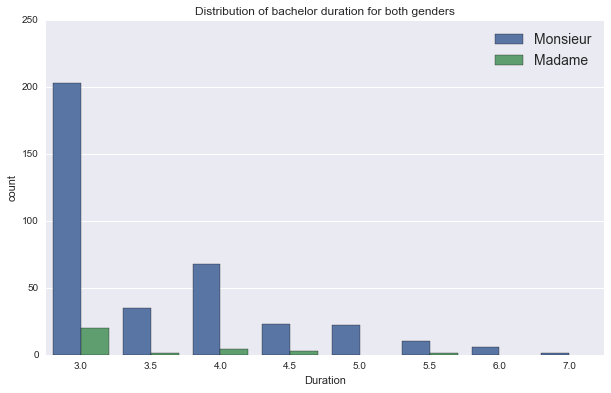

In [19]:
#Histogram of the previous results
resultMen = result[result['Civilite'] == 'Monsieur']
resultWomen = result[result['Civilite'] == 'Madame']

plt.figure(figsize=(10,6))
sns.countplot(result['Duration'], hue=result['Civilite'])
plt.legend(loc='upper right',prop={'size':14})
sns.plt.title('Distribution of bachelor duration for both genders');

### Hypothesis testing

Regarding the distributions of the durations of bachelors for men and women we do the following hypothesis:
* Our null hypothesis $H_0$ is: the duration of men and women follow the same distribution
* Thus the alternative hypothesis $H_A$ is that the distributions differ
* We do a two-samples t-test to test this
* We choose a significance level of $\alpha = 0.05$

In [20]:
mean_women = resultWomen.Duration.mean()
mean_men = resultMen.Duration.mean()

s = mean_men - mean_women

print('Men take on average', round(s, 3),'more years to complete their bachelor than women')

stats.ttest_ind(a=resultMen.Duration, b=resultWomen.Duration, equal_var=True)

Men take on average 0.177 more years to complete their bachelor than women


Ttest_indResult(statistic=1.1743739616350912, pvalue=0.24095278708853646)

### Results
The t-test yields a p-value of 0.24 i.e. we cannot reject the null hypoythesis at the 0.05 level. On a side note, the statistical bias regarding the proportion of men and women is very high (7.8% of women) so computing differences in distribution is somewhat not statistically relevant.

## 2. 

In [21]:
#ISA base url. This is the page that displays the form
isa_base_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'

#list of ID of academic periods, from 2007-2008 to 2016-2017
academic_periods = [978181, 978187, 978195, 39486325, 123455150, 123456101, 213637754, 213637922, 213638028, 355925344]

#list of ID of semesters (Master semester 1,2 and 3 as well as Project semestre printemps and automne)
semesters_master = [2230106,942192,2230128,249127, 3781783]

#list of parameters (found using Postman)
params_dict = {'ww_x_GPS': -1,
               'ww_i_reportmodel': 133685247,
               'ww_i_reportModelXsl': 133685270,
               'ww_x_UNITE_ACAD': 249847,
               'ww_x_PERIODE_ACAD': 978181,
               'ww_x_PERIODE_PEDAGO': 249108,
               'ww_x_HIVERETE': 'null',
               }

#empty Series, data will be appened at each iteration
data_masters = {'Sciper': [], 'Civilite': [], 'Nom': [],'Mineur' : [], 'Spe' : [],
                'Statut' : [], 'Semester' : [],'Sem_Year' : []}

#Iteration on all the entries
for current_year in academic_periods :
    params_dict['ww_x_PERIODE_ACAD'] = current_year
    for current_semester in semesters_master :
        params_dict['ww_x_PERIODE_PEDAGO'] = current_semester
        
        #Fetch of html table for given year and semester type
        resp = requests.get(isa_base_url, params=params_dict)
        data_masters_list = resp.text
        soup = BeautifulSoup(data_masters_list, 'html.parser')
        
        #Obtention of the needed information (year and semester_type)
        table = soup.findAll('table')[0]
        rows = table.findAll('tr')[2:]
        semester_infos_master = re.search('Informatique, (\d+-\d+), (.*)\n\xa0\(.*\)',
                                          table.findAll('tr')[0].findAll('th')[0].get_text())
        
        #Iteration on each row, appending the important informations to the Series
        for row in rows:
            cols = row.findAll('td')
            data_masters['Sciper'].append(int(cols[10].get_text()))
            data_masters['Civilite'].append(cols[0].get_text())
            data_masters['Nom'].append(cols[1].get_text())
            data_masters['Mineur'].append(cols[6].get_text())
            data_masters['Spe'].append(cols[4].get_text())
            data_masters['Statut'].append(cols[7].get_text())
            data_masters['Semester'].append(semester_infos_master.group(2))
            data_masters['Sem_Year'].append(semester_infos_master.group(1))
            
#DataFrame created from the Series. We use the Sciper as well as the Name for multi-indexing.    
df = pd.DataFrame(data_masters)
df = df[df['Statut'] != 'Congé']
df.sort_values(['Sciper','Nom'], inplace=True)
df = df.set_index(['Sciper', 'Nom'])

## Data Cleaning
In order to achieve the same results as in the Bachelor problem. We made a few assumptions:
* We don't use the entries in which the student is marked as not here ("Congé")
* If the student has no entries for the Master Semestre 1, we drop all his entries
* If the student is still registered in the current year (2016-2107) and not currently doing his master project, we don't consider him, as he will graduate later than now.

In [22]:
for s in df.index.levels[0]:
    subframe = df.loc[s]    
    semester = subframe['Semester'].values
    years = subframe['Sem_Year'].values
    statut = subframe['Statut'].values
    
    if not 'Master semestre 1' in semester:
         df = df.drop(s, level = 0)
    elif 'Master semestre 1' in semester and len(semester) == 1:
        df = df.drop(s, level = 0)
    elif '2016-2017' in years and not 'Projet Master automne' in semester:
        df = df.drop(s, level = 0)
    elif 'Congé' in statut:
        print(subframe['Statut'] == 'Congé')
        df = df.drop(subframe[subframe['Statut'] == 'Congé'].index(level = 1), level = 1)

df = df.reset_index().set_index(['Sciper', 'Nom'])

#Small preview of the cleaned Data
df.ix[0:10]

Civilite Mineur   Sem_Year               Semester  \
Sciper Nom                                                                   
146330 Cardinaux Damien  Monsieur         2007-2008      Master semestre 1   
       Cardinaux Damien  Monsieur         2007-2008      Master semestre 2   
       Cardinaux Damien  Monsieur         2008-2009      Master semestre 3   
146742 Marx Clément      Monsieur         2008-2009      Master semestre 1   
       Marx Clément      Monsieur         2008-2009      Master semestre 2   
       Marx Clément      Monsieur         2009-2010      Master semestre 2   
       Marx Clément      Monsieur         2009-2010      Master semestre 3   
       Marx Clément      Monsieur         2010-2011  Projet Master automne   
       Marx Clément      Monsieur         2012-2013      Master semestre 3   
146929 Junod Antoine     Monsieur         2007-2008      Master semestre 1   

                                                    Spe   Statut  
Sciper Nom                                                        
146330 Cardinaux Damien                                  Présent  
       Cardinaux Damien                                  Présent  
       Cardinaux Damien                                  Présent  
146742 Marx Clément      Signals, Images and Interfaces  Présent  
       Marx Clément      Signals, Images and Interfaces  Présent  
       Marx Clément      Signals, Images and Interfaces  Présent  
       Marx Clément      Signals, Images and Interfaces  Présent  
       Marx Clément      Signals, Images and Interfaces  Présent  
       Marx Clément      Signals, Images and Interfaces  Présent  
146929 Junod Antoine                                     Présent

## Assumptions concerning Master Project
The main problem of this dataset is that the entries concerning the Master Thesis (*Projet Master automne* and *projet Master printemps*) appear to be reliable only for this year. For the past 10 years, thoses entries only have a few students, therefore we had to make assumptions based on the available data.


First we consider the most recent occurence in our entries. 
* If this occurence is a Master Project semester, we consider it as the final semester of studies.
* If this occurence is not a Master Project semester (thus a regular classes semester), it means that the student should at least do another semester for this master project, maybe even a complete year if he has not done his intership yet.
* We did the assumption that the internship was already done, as we had no way to obtain this information. Therefore we simply add a semester for the master Project.


In [23]:
scipers = []
names = []
civilites = []
durations = []
spes = []

#Iteration over all the entries (using only first level of multi-indexing)
for s in df.index.levels[0]:
    subframe = df.loc[s]
    
    scipers.append(s)
    names.append(subframe.index[0])
    civilites.append(subframe['Civilite'].values[0])
    
    #Check if the student has chosen a specialization or not
    current_spe = list(filter(None, subframe['Spe'].unique()))
    spes.append(current_spe[0] if current_spe else None)
    
    minDate = subframe.Sem_Year.values.min()
    maxDate = subframe.Sem_Year.values.max()
    
    #Fetch of the semester type occurencies in the first and last year
    startSemester = subframe.loc[subframe['Sem_Year'] == minDate].Semester.values
    endSemester = subframe.loc[subframe['Sem_Year'] == maxDate].Semester.values
    
    #If the first year only contains one semester, it means that the student has begin
    #his master in february, otherwise he did it in september
    if len(startSemester) == 1:
        startYear = int(minDate[:4]) + 1
    else:
        startYear = int(minDate[:4]) + 0.5
    
    #Check for the occurence of any Master Semester project during the last year
    if any('Projet Master printemps' in s for s in endSemester.tolist()):
        endYear = int(maxDate[:4]) + 1.5
    elif any('Projet Master automne' in s for s in endSemester.tolist()):
        endYear = int(maxDate[:4]) + 1
    else:
        #Check for the presence of "Master Semestre 2" in the last year of studies,
        #meaning that the student has done a complete year of classes and that he
        #needs at least one more semester to complete his studies.
        if any('2' in s for s in endSemester.tolist()):
            endYear = int(maxDate[:4]) + 2 
        else:
            endYear = int(maxDate[:4]) + 1.5
            
    durations.append(endYear-startYear)
    
    #Creation of the DataFrame
    ma = pd.DataFrame({'Sciper': scipers, 'Name': names, 'Civilite': civilites,
                       'Specialization': spes, 'Duration': durations})
    
ma.sort_values(['Duration'], inplace=True)
ma.set_index(['Sciper'])

,Civilite,Duration,Name,Specialization
Sciper,,,,
195213,Monsieur,1.5,Drissi El Kamili Souleimane,None
184647,Monsieur,1.5,Studer Emeric,None
184844,Monsieur,1.5,Franscella Mattia,None
185161,Monsieur,1.5,Laquerre Pierre-François,"Signals, Images and Interfaces"
185541,Monsieur,1.5,Jocic Momcilo,None
185607,Monsieur,1.5,Bakshev Stanimir,None
185952,Monsieur,1.5,Cuony Maximilien,None
185975,Monsieur,1.5,Sanglard Nicolas,None
190920,Monsieur,1.5,Vu Tuan Thanh,None


### Hypothesis testing
We do the same hypothesis than for the bachelor students, i.e.:
* The general duration and the duration for each specialization shold follow the same distribution

In [24]:
avg_stay = ma.Duration.mean()
print("The average stay at EPFL is", avg_stay)

frame = ma[['Duration', 'Specialization']]
spe_grouped = frame.groupby(['Specialization']).mean()
print('\nWe have the following average by specialization:\n',spe_grouped)

The average stay at EPFL is 2.09640522875817

We have the following average by specialization:
                                 Duration
Specialization                          
Biocomputing                    2.500000
Computer Engineering - SP       2.178571
Foundations of Software         2.336735
Information Security - SP       2.500000
Internet computing              2.328767
Service science                 2.300000
Signals, Images and Interfaces  2.562500
Software Systems                2.300000


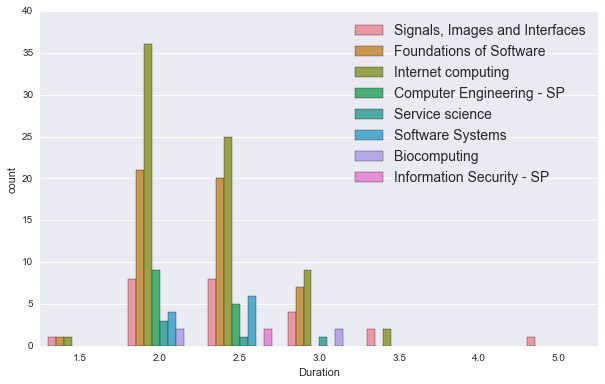

In [25]:
plt.figure(figsize=(10,6))
plot_duration = sns.countplot(ma['Duration'], hue=ma['Specialization']);
plt.legend(loc='upper right',prop={'size':14});

In [26]:
temp = ma[['Specialization', 'Duration', 'Name']]
temp = temp.dropna()
specs = temp['Specialization'].unique()
for spec in specs:
    sample = temp[temp['Specialization'] == spec]
    print("specialization: ",spec,", p-value: ", stats.ttest_ind(a=sample.Duration, b=ma.Duration, equal_var=False)[1])

specialization:  Signals, Images and Interfaces , p-value:  0.00474855564969
specialization:  Foundations of Software , p-value:  7.68013674663e-05
specialization:  Internet computing , p-value:  1.92210994035e-05
specialization:  Computer Engineering - SP , p-value:  0.252898934481
specialization:  Service science , p-value:  0.367245073754
specialization:  Software Systems , p-value:  0.0355518189877
specialization:  Biocomputing , p-value:  0.256602659249
specialization:  Information Security - SP , p-value:  1.19119709788e-74


### Results
We can see that some p-values are under the threshold $\alpha = 0.05$. We can reject the null hypothesis for the following specializations:
* Signals, Images and Interfaces
* Foundations of Software
* Internet computing
* Software Systems
* Information Security

This can be explained by the size of the samples, indeed some specialization have very few students and it's logical that such small samples do not follow the same distribution than all the masters students

In [27]:
temp.groupby(['Specialization', 'Duration']).count()

Name
Specialization                 Duration      
Biocomputing                   2.0          2
                               3.0          2
Computer Engineering - SP      2.0          9
                               2.5          5
Foundations of Software        1.5          1
                               2.0         21
                               2.5         20
                               3.0          7
Information Security - SP      2.5          2
Internet computing             1.5          1
                               2.0         36
                               2.5         25
                               3.0          9
                               3.5          2
Service science                2.0          3
                               2.5          1
                               3.0          1
Signals, Images and Interfaces 1.5          1
                               2.0          8
                               2.5          8
                               3.0          4
                               3.5          2
                               5.0          1
Software Systems               2.0          4
                               2.5          6